 # Capstone Project 2 - EDA
## Name: Brock Nosbisch

#### Summary:
This is a continuation from the "Capstone Project 2 - Data Wrangling" and "Capstone Project 2 - Data Story" notebooks. The data from the Data Story notebook was written to the data_story_out.csv file which is read into this notebook.  

The problem I am trying to solve is to predict if a customer will turn off in XX number of days.  The end goal is to come up with the best algorithm that produces the best Score (probability of turning off in XX number of days).  

For this project I am using the date of 3/1/2019 as the beginning date for the stops and then looking at timeframes of 7 days, 14 days, and 21 days.  I've created 2 dataframes for this notebook.  The first dataset contains all data and is only used in the ANNEX section; the second dataset only has data for SAs that were active as of 3/1/2019.  The 2nd dataset is needed so that we can see the actual Active SAs as of the date we are predicting stops from.

The STOP_7_DAYS_FROM_20190301, STOP_14_DAYS_FROM_20190301, and STOP_21_DAYS_FROM_20190301 fields were added to the dataset to show if the SA stopped in the specified timeframe from 3/1/2019.  The values are 0 if not stopped and 1 if stopped.  

After performing EDA, there are several correlations that are of statistical significance and a few that have practical significance.  

When comparing the Pearson correlation between Late Payment Counts and Stopping 21 Days from 3/1/2019, it has a p-value > .05 so the Null Hypothesis holds true.  We can assume there is no significant correlation between these 2 values.

Also, the # of Days Active as of 3/1/2019 has a negative correlation with Stopping.  So in other words, the less days you have been active, the more likely you are to stop within 21 days of 3/1/2019.

Based on the Bootstrap Estimate using the dataset with Active SAs as of 3/1/2019, the 95% confidence interval for the number of SAs Stopping between 3/1/2019 and 3/7/2019 is from .34% to .38%.  For active SAs on 3/1/2019, the 95% confidence interval for the number of SAs Stopping between 3/1/2019 and 3/14/2019 is from .67% to .72%.  And for active SAs on 3/1/2019, the 95% confidence interval for the number of SAs Stopping between 3/1/2019 and 3/21/2019 is from .98% to 1.04%.

I used Lasso for Feature Selection and the results for different alpha values.  At a low value, the results show the Bills in last 18 months, DNP Stopped Flag, and SA End Avg Temperature as the top features.

# Load Data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from datetime import datetime, date

from scipy import stats
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler


# Functions #

def add_value_labels(ax, spacing=5):

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        va = 'bottom'

        if y_value < 0:
            space *= -1
            # Vertical alignment
            va = 'top'

        label = "{:}".format(y_value)  # Use :.1f if wanting decimals.

        # Create annotation
        ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va=va) 
        
def pearsonr_ci(x,y,alpha=0.05):

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    low_z, high_z = r_z-z*se, r_z+z*se
    low, high = np.tanh((low_z, high_z))
    return r, p, low, high

# Bootstrap Replicates
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))


file_name = 'data_story_out.csv' # Service Agreement Level

df=pd.DataFrame()

# Read in the file with new column names.
df = pd.read_csv(file_name, header=0)

df.set_index('SA_ID', inplace=True)


# Change Data Types #
df = df.astype({'ACCOUNT_ID':'str', 
                'PERSON_ID':'str', 
                'SA_STATUS_FLAG':'str', 
                'PREMISE_ID':'str',
                'POSTAL':'str',
                'SA_START_YEAR':'str',
                'SA_START_YEAR_MONTH':'str',
                'SA_END_YEAR':'str',
                'SA_END_YEAR_MONTH':'str',
                'SA_START_DATE':'datetime64[ns]',
                'SA_END_DATE':'datetime64[ns]',
                'MOST_RECENT_PAYMENT_DATE':'datetime64[ns]',
                'PERSON_MAX_SA_START_DATE':'datetime64[ns]',
                'PERSON_MIN_SA_START_DATE':'datetime64[ns]',   
                'PERSON_MAX_SA_END_DATE':'datetime64[ns]',
                'PERSON_MIN_SA_END_DATE':'datetime64[ns]',
                'PREMISE_MAX_SA_START_DATE':'datetime64[ns]',
                'PREMISE_MIN_SA_START_DATE':'datetime64[ns]',
                'PREMISE_MAX_SA_END_DATE':'datetime64[ns]',
                'PREMISE_MIN_SA_END_DATE':'datetime64[ns]',
                'PREMISE_PRIOR_STOP_DATE':'datetime64[ns]',
                'PERSON_PRIOR_STOP_DATE':'datetime64[ns]',
                'PLEDGE_DATE_2013':'datetime64[ns]',
                'PLEDGE_DATE_2014':'datetime64[ns]',
                'PLEDGE_DATE_2015':'datetime64[ns]',
                'PLEDGE_DATE_2016':'datetime64[ns]',
                'PLEDGE_DATE_2017':'datetime64[ns]',
                'PLEDGE_DATE_2018':'datetime64[ns]',
                'PLEDGE_DATE_2019':'datetime64[ns]'
               })

# Dropping 2 columns that have no data. Source Applications must not have tracked Pledges in 2013, 2014.
del df['PLEDGE_DATE_2013']
del df['PLEDGE_DATE_2014']

print()

#### Create a copy of the DataFrame that only contains active SAs as of 3/1/2019.

In [30]:
# df2 is a copy of df but only has SAs that should be considered when looking at stops from 3/1/2019.
df2 = df.copy() 
df2 = df2.loc[((df2['SA_START_YEAR_MONTH']  < '201903') & (df2['SA_END_YEAR_MONTH'] >= '201903') )]
#df2 = df2.drop(['STOP_2013','STOP_2014','STOP_2015','STOP_2016','STOP_2017','STOP_2018'], axis=1)

del df2['STOP_2013']
del df2['STOP_2014']
del df2['STOP_2015']
del df2['STOP_2016']
del df2['STOP_2017']
del df2['STOP_2018']


# Update dataset to have 0,1 values for flags. #

# DNP Started
df2['DNP_STARTED_FLAG_NUMBER'] = 0
df2.loc[((df2['DNP_STARTED_FLAG'] == 'Y')), 'DNP_STARTED_FLAG_NUMBER'] = 1

# DNP Stopped
df2['DNP_STOPPED_FLAG_NUMBER'] = 0
df2.loc[((df2['DNP_STOPPED_FLAG'] == 'Y')), 'DNP_STOPPED_FLAG_NUMBER'] = 1

# Person Received Pledge in Last 18 Months
df2['PERSON_RCVD_18_MTHS_PLEDGE_NUM'] = 0
df2.loc[((df2['PERSON_RCVD_18_MTHS_PLEDGE'] == 'Y')), 'PERSON_RCVD_18_MTHS_PLEDGE_NUM'] = 1

# Seasonal Customer Last Year
df2['SEASONAL_PRIOR_1_YR_FLAG_NUM'] = 0
df2.loc[((df2['SEASONAL_PRIOR_1_YR_FLAG'] == 'Y')), 'SEASONAL_PRIOR_1_YR_FLAG_NUM'] = 1

# Seasonal Customer 2 Years Ago
df2['SEASONAL_PRIOR_2_YR_FLAG_NUM'] = 0
df2.loc[((df2['SEASONAL_PRIOR_2_YR_FLAG'] == 'Y')), 'SEASONAL_PRIOR_2_YR_FLAG_NUM'] = 1

# Seasonal Customer 3 Years Ago
df2['SEASONAL_PRIOR_3_YR_FLAG_NUM'] = 0
df2.loc[((df2['SEASONAL_PRIOR_3_YR_FLAG'] == 'Y')), 'SEASONAL_PRIOR_3_YR_FLAG_NUM'] = 1

df2['SEASONAL_PRIOR_3_YR_FLAG_NUM'] = 0
df2.loc[((df2['SEASONAL_PRIOR_3_YR_FLAG'] == 'Y')), 'SEASONAL_PRIOR_3_YR_FLAG_NUM'] = 1

# Create 0,1 values for Pledge Dates for 2017 and 2018.
df2['PLEDGE_DATE_2017_NUM'] = 1
df2.loc[(df2['PLEDGE_DATE_2017'].isna()), 'PLEDGE_DATE_2017_NUM'] = 0
df2['PLEDGE_DATE_2018_NUM'] = 1
df2.loc[(df2['PLEDGE_DATE_2018'].isna()), 'PLEDGE_DATE_2018_NUM'] = 0

# Used for train_test_split.
X = df2[['DNP_STARTED_FLAG_NUMBER','DNP_STOPPED_FLAG_NUMBER','INTERNAL_CREDIT_RATING','PERSON_RCVD_18_MTHS_PLEDGE_NUM','PAYMENTS_IN_LAST_18_MONTHS','BILLS_IN_LAST_18_MONTHS','ARREARS_PAYOFF_AMOUNT','TOTAL_PAYOFF_AMOUNT','LATE_PAYMENT_COUNT','SEASONAL_PRIOR_1_YR_FLAG_NUM','SEASONAL_PRIOR_2_YR_FLAG_NUM','SEASONAL_PRIOR_3_YR_FLAG_NUM','SA_START_AVG_TEMP','SA_END_AVG_TEMP','START_2013','START_2014','START_2015','START_2016','START_2017','START_2018','START_2019','PLEDGE_DATE_2017_NUM','PLEDGE_DATE_2018_NUM','PREMISE_DAYS_INACTIVE_BEFORE','PERSON_DAYS_INACTIVE_BEFORE','PREMISE_DAYS_ACTIVE_BEFORE','PERSON_DAYS_ACTIVE_BEFORE','ACTIVE_DIFF_FROM_20190301']]
y = df2['STOP_21_DAYS_FROM_20190301']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)


# Continuous Variables w/ Stop Flags
cont_vars = ['INTERNAL_CREDIT_RATING','PAYMENTS_IN_LAST_18_MONTHS','BILLS_IN_LAST_18_MONTHS','PAY_SEGS_IN_LAST_18_MONTHS','BILL_SEGS_IN_LAST_18_MONTHS','ARREARS_CURRENT_AMOUNT','ARREARS_PAYOFF_AMOUNT','TOTAL_CURRENT_AMOUNT','TOTAL_PAYOFF_AMOUNT','LATE_PAYMENT_COUNT','SA_START_AVG_TEMP','SA_END_AVG_TEMP','USAGE_IN_LAST_18_MONTHS','PREMISE_DAYS_INACTIVE_BEFORE','PERSON_DAYS_INACTIVE_BEFORE','PREMISE_DAYS_ACTIVE_BEFORE','PERSON_DAYS_ACTIVE_BEFORE','ACTIVE_DIFF_FROM_20190301','STOP_7_DAYS_FROM_20190301','STOP_14_DAYS_FROM_20190301','STOP_21_DAYS_FROM_20190301']


print()

# EDA Summary
### All data in the EDA Summary is using the dataset that only has Active SAs as of 3/1/2019.

## Pearson Correlation

The Pearson Correlation is showing some intuitive correlations like positive correlations between Payments/Bills, Bills/# of Days Active, and SA End Avg Temp/Stops and negative correlations between Stops and Bill/Payments.

There are also some interesting negative correlations between # of days currently active and # of days the same person was previously active.  Another interesting negative correlation is between # of days a Person was previously active for and the same Person was previously off before starting the current SA.

In [31]:
df2[cont_vars].corr(method='pearson')

,INTERNAL_CREDIT_RATING,PAYMENTS_IN_LAST_18_MONTHS,BILLS_IN_LAST_18_MONTHS,PAY_SEGS_IN_LAST_18_MONTHS,BILL_SEGS_IN_LAST_18_MONTHS,ARREARS_CURRENT_AMOUNT,ARREARS_PAYOFF_AMOUNT,TOTAL_CURRENT_AMOUNT,TOTAL_PAYOFF_AMOUNT,LATE_PAYMENT_COUNT,...,SA_END_AVG_TEMP,USAGE_IN_LAST_18_MONTHS,PREMISE_DAYS_INACTIVE_BEFORE,PERSON_DAYS_INACTIVE_BEFORE,PREMISE_DAYS_ACTIVE_BEFORE,PERSON_DAYS_ACTIVE_BEFORE,ACTIVE_DIFF_FROM_20190301,STOP_7_DAYS_FROM_20190301,STOP_14_DAYS_FROM_20190301,STOP_21_DAYS_FROM_20190301
INTERNAL_CREDIT_RATING,1.000000,0.009527,-0.095566,0.009527,-0.095566,-0.056935,-0.055699,-0.038716,-0.037612,-0.003570,...,0.006772,0.001156,0.008550,0.001892,0.032282,-0.002887,-0.032171,0.017857,0.014412,0.017559
PAYMENTS_IN_LAST_18_MONTHS,0.009527,1.000000,0.754084,1.000000,0.754084,-0.060093,-0.054117,-0.044821,-0.037147,-0.106905,...,-0.258331,0.034729,-0.158201,-0.075928,-0.097959,-0.057801,0.383108,-0.068448,-0.100550,-0.120773
BILLS_IN_LAST_18_MONTHS,-0.095566,0.754084,1.000000,0.754084,1.000000,-0.018146,-0.009411,-0.015775,-0.006784,0.103482,...,-0.255604,0.017838,-0.172707,-0.087535,-0.131217,-0.074042,0.385541,-0.076101,-0.103376,-0.124873
PAY_SEGS_IN_LAST_18_MONTHS,0.009527,1.000000,0.754084,1.000000,0.754084,-0.060093,-0.054117,-0.044821,-0.037147,-0.106905,...,-0.258331,0.034729,-0.158201,-0.075928,-0.097959,-0.057801,0.383108,-0.068448,-0.100550,-0.120773
BILL_SEGS_IN_LAST_18_MONTHS,-0.095566,0.754084,1.000000,0.754084,1.000000,-0.018146,-0.009411,-0.015775,-0.006784,0.103482,...,-0.255604,0.017838,-0.172707,-0.087535,-0.131217,-0.074042,0.385541,-0.076101,-0.103376,-0.124873
ARREARS_CURRENT_AMOUNT,-0.056935,-0.060093,-0.018146,-0.060093,-0.018146,1.000000,0.975279,0.531664,0.524987,0.088057,...,0.039638,0.081627,0.017775,-0.008195,0.004393,0.000984,-0.031941,0.016146,0.028301,0.033962
ARREARS_PAYOFF_AMOUNT,-0.055699,-0.054117,-0.009411,-0.054117,-0.009411,0.975279,1.000000,0.521475,0.543393,0.080236,...,0.035210,0.080175,0.016548,-0.007153,-0.000122,-0.001141,-0.014803,0.013716,0.025012,0.030021
TOTAL_CURRENT_AMOUNT,-0.038716,-0.044821,-0.015775,-0.044821,-0.015775,0.531664,0.521475,1.000000,0.989916,0.056620,...,0.031565,0.065746,0.013936,-0.004377,0.007705,0.000323,-0.025146,0.011291,0.019774,0.023847
TOTAL_PAYOFF_AMOUNT,-0.037612,-0.037147,-0.006784,-0.037147,-0.006784,0.524987,0.543393,0.989916,1.000000,0.052096,...,0.023832,0.065402,0.011252,-0.004560,0.004899,-0.001074,-0.011791,0.009319,0.016915,0.020374
LATE_PAYMENT_COUNT,-0.003570,-0.106905,0.103482,-0.106905,0.103482,0.088057,0.080236,0.056620,0.052096,1.000000,...,0.007538,-0.002329,-0.016279,0.010057,0.011121,0.018796,-0.019756,-0.003376,0.003711,0.002564


Here is the heatmap for the above Pearson Correlation.

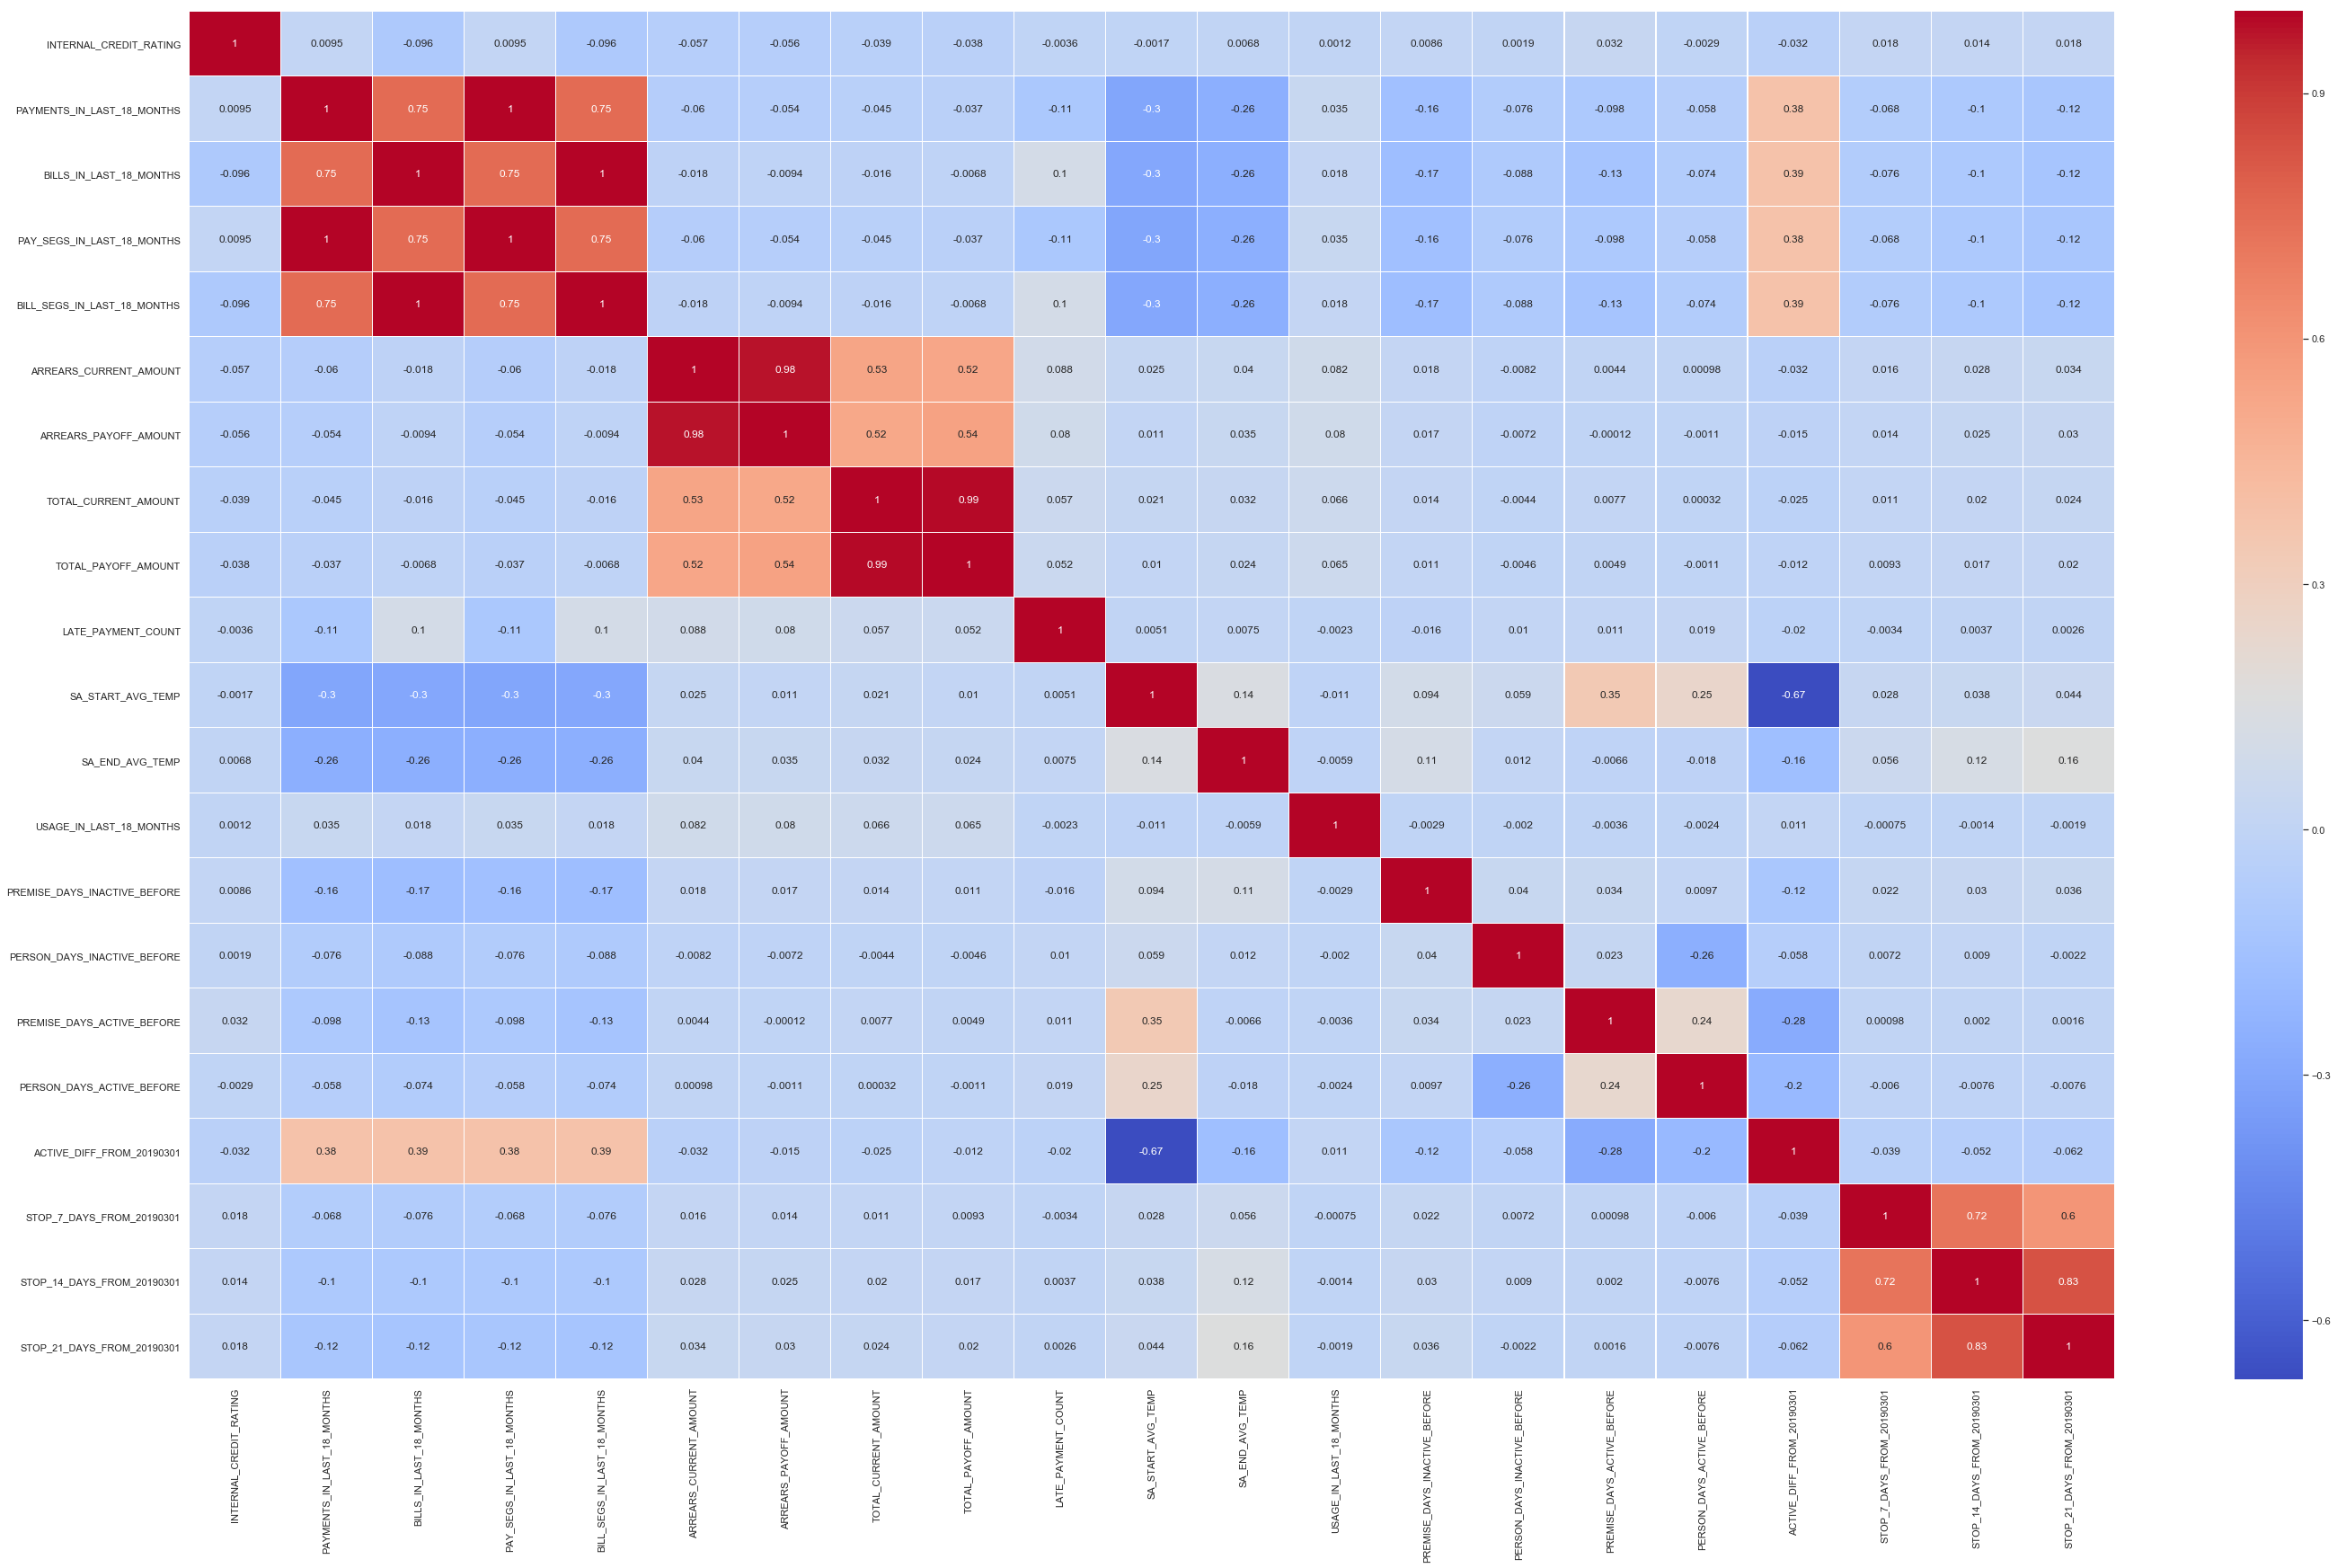

In [32]:
fig, ax = plt.subplots(figsize=(48,28))

# sns.set(font_scale=2.5)
sns.heatmap(df2[cont_vars].corr(method='pearson'), annot=True, linewidth=.1, cmap='coolwarm')
#sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})  
# plt.xticks(fontsize=28, rotation=90)
# plt.yticks(fontsize=28, rotation=0)

plt.show()

Setup an appropriate hypothesis test.
* Null Hypothesis: There is no significant correlation between Stopping 21 Days from 3/1/2019 and Late Payment Count.
* Alternative Hypothesis: There is a significant correlation between Stopping 21 Days from 3/1/2019 and Late Payment Count.
<br>

The below shows the Late Payment Count correlation to Stopping 21 Days from 3/1/2019.  It has a p-value > .05 so the Null Hypothesis holds true.

In [33]:
r, p, low, high = pearsonr_ci(x=df2['LATE_PAYMENT_COUNT'], y=df2['STOP_21_DAYS_FROM_20190301'], alpha=.05)

print('Dependent: Stopped within 21 Days of 3/1/2019')
print('Independent: Late Payment Count')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Stopped within 21 Days of 3/1/2019
Independent: Late Payment Count
p-value: 0.13422258577815704
r: 0.0025639475928595935
r^2: 6.573827258930504e-06
CI: -0.0007914607258690424 to 0.005919298178435303


Setup an appropriate hypothesis test.
* Null Hypothesis: There is no significant correlation between Payments in Last 18 Months and Bills in Last 18 Months.
* Alternative Hypothesis: There is a significant correlation between Payments in Last 18 Months and Bills in Last 18 Months.
<br>

The below shows the Payments in Last 18 Months correlates to Bills in Last 18 Months  The tests have a p-value < .05 so there is a statistical significance in the correlations and it shows that there is practical significance since r^2 is quite high at .57.  But we do intuitively know that the # of Payments is correlated to # of Bills so the more Bills you receive, the more Payments you will make.

In [34]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df2['PAYMENTS_IN_LAST_18_MONTHS'], y=df2['BILLS_IN_LAST_18_MONTHS'], alpha=.05)

print('Dependent: Bills in Last 18 Months')
print('Independent: Payments in Last 18 Months')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Bills in Last 18 Months
Independent: Payments in Last 18 Months
p-value: 0.0
r: 0.7540840590767648
r^2: 0.5686427681536896
CI: 0.7526330108480614 to 0.7555277827948829


Setup an appropriate hypothesis test.
* Null Hypothesis: There is no significant correlation between Total Payoff Amount and Late Payment Count.
* Alternative Hypothesis: There is a significant correlation between Total Payoff Amount and Late Payment Count.
<br>

The below shows the Total Payoff Amount correlation to Late Payment Count.  The test has a p-value < .05 so there is a statistical significance in the correlations and it shows that there is some practical significance since r^2 is > .1%.


In [35]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df2['TOTAL_PAYOFF_AMOUNT'], y=df2['LATE_PAYMENT_COUNT'], alpha=.05)

print('Dependent: Late Payment Count')
print('Independent: Total Payoff Amount')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Late Payment Count
Independent: Total Payoff Amount
p-value: 1.1659853164553917e-203
r: 0.05209579241510652
r^2: 0.00271397158735787
CI: 0.04874891232739548 to 0.05544150262263752


The below is showing that the # of Days Active as of 3/1/2019 has a negative correlation with Stopping.  So in other words, the less days you have been active, the more likely you are to stop with 21 days of 3/1/2019.

In [36]:
df2[['ACTIVE_DIFF_FROM_20190301','STOP_7_DAYS_FROM_20190301','STOP_14_DAYS_FROM_20190301','STOP_21_DAYS_FROM_20190301']].corr(method='pearson')

,ACTIVE_DIFF_FROM_20190301,STOP_7_DAYS_FROM_20190301,STOP_14_DAYS_FROM_20190301,STOP_21_DAYS_FROM_20190301
ACTIVE_DIFF_FROM_20190301,1.000000,-0.039183,-0.052372,-0.062117
STOP_7_DAYS_FROM_20190301,-0.039183,1.000000,0.719951,0.598378
STOP_14_DAYS_FROM_20190301,-0.052372,0.719951,1.000000,0.831137
STOP_21_DAYS_FROM_20190301,-0.062117,0.598378,0.831137,1.000000


To prove the above out, setup an appropriate hypothesis test.
* Null Hypothesis: There is no significant correlation between being # of Active Days as of 3/1/2019 and Stopping within 21 days of 3/1/2019.
* Alternative Hypothesis: There is a significant correlation between being # of Active Days as of 3/1/2019 and Stopping within 21 days of 3/1/2019.
<br>

As expected, the below shows the that the # of Active Days as of 3/1/2019 is negatively correlated with Stopping within 21 days of 3/1/2019.  

In [37]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df2['ACTIVE_DIFF_FROM_20190301'], y=df2['STOP_21_DAYS_FROM_20190301'], alpha=.05)

print('Dependent: Stopped within 21 Days of 3/1/2019')
print('Independent: # of Days Active as of 3/1/2019')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Stopped within 21 Days of 3/1/2019
Independent: # of Days Active as of 3/1/2019
p-value: 8.115190581846711e-289
r: -0.0621171970098507
r^2: 0.003858546164360605
CI: -0.06545895503156166 to -0.05877404566493696


## Spearman Correlation

Heatmap using the dataset with only active SAs on 3/1/2019.

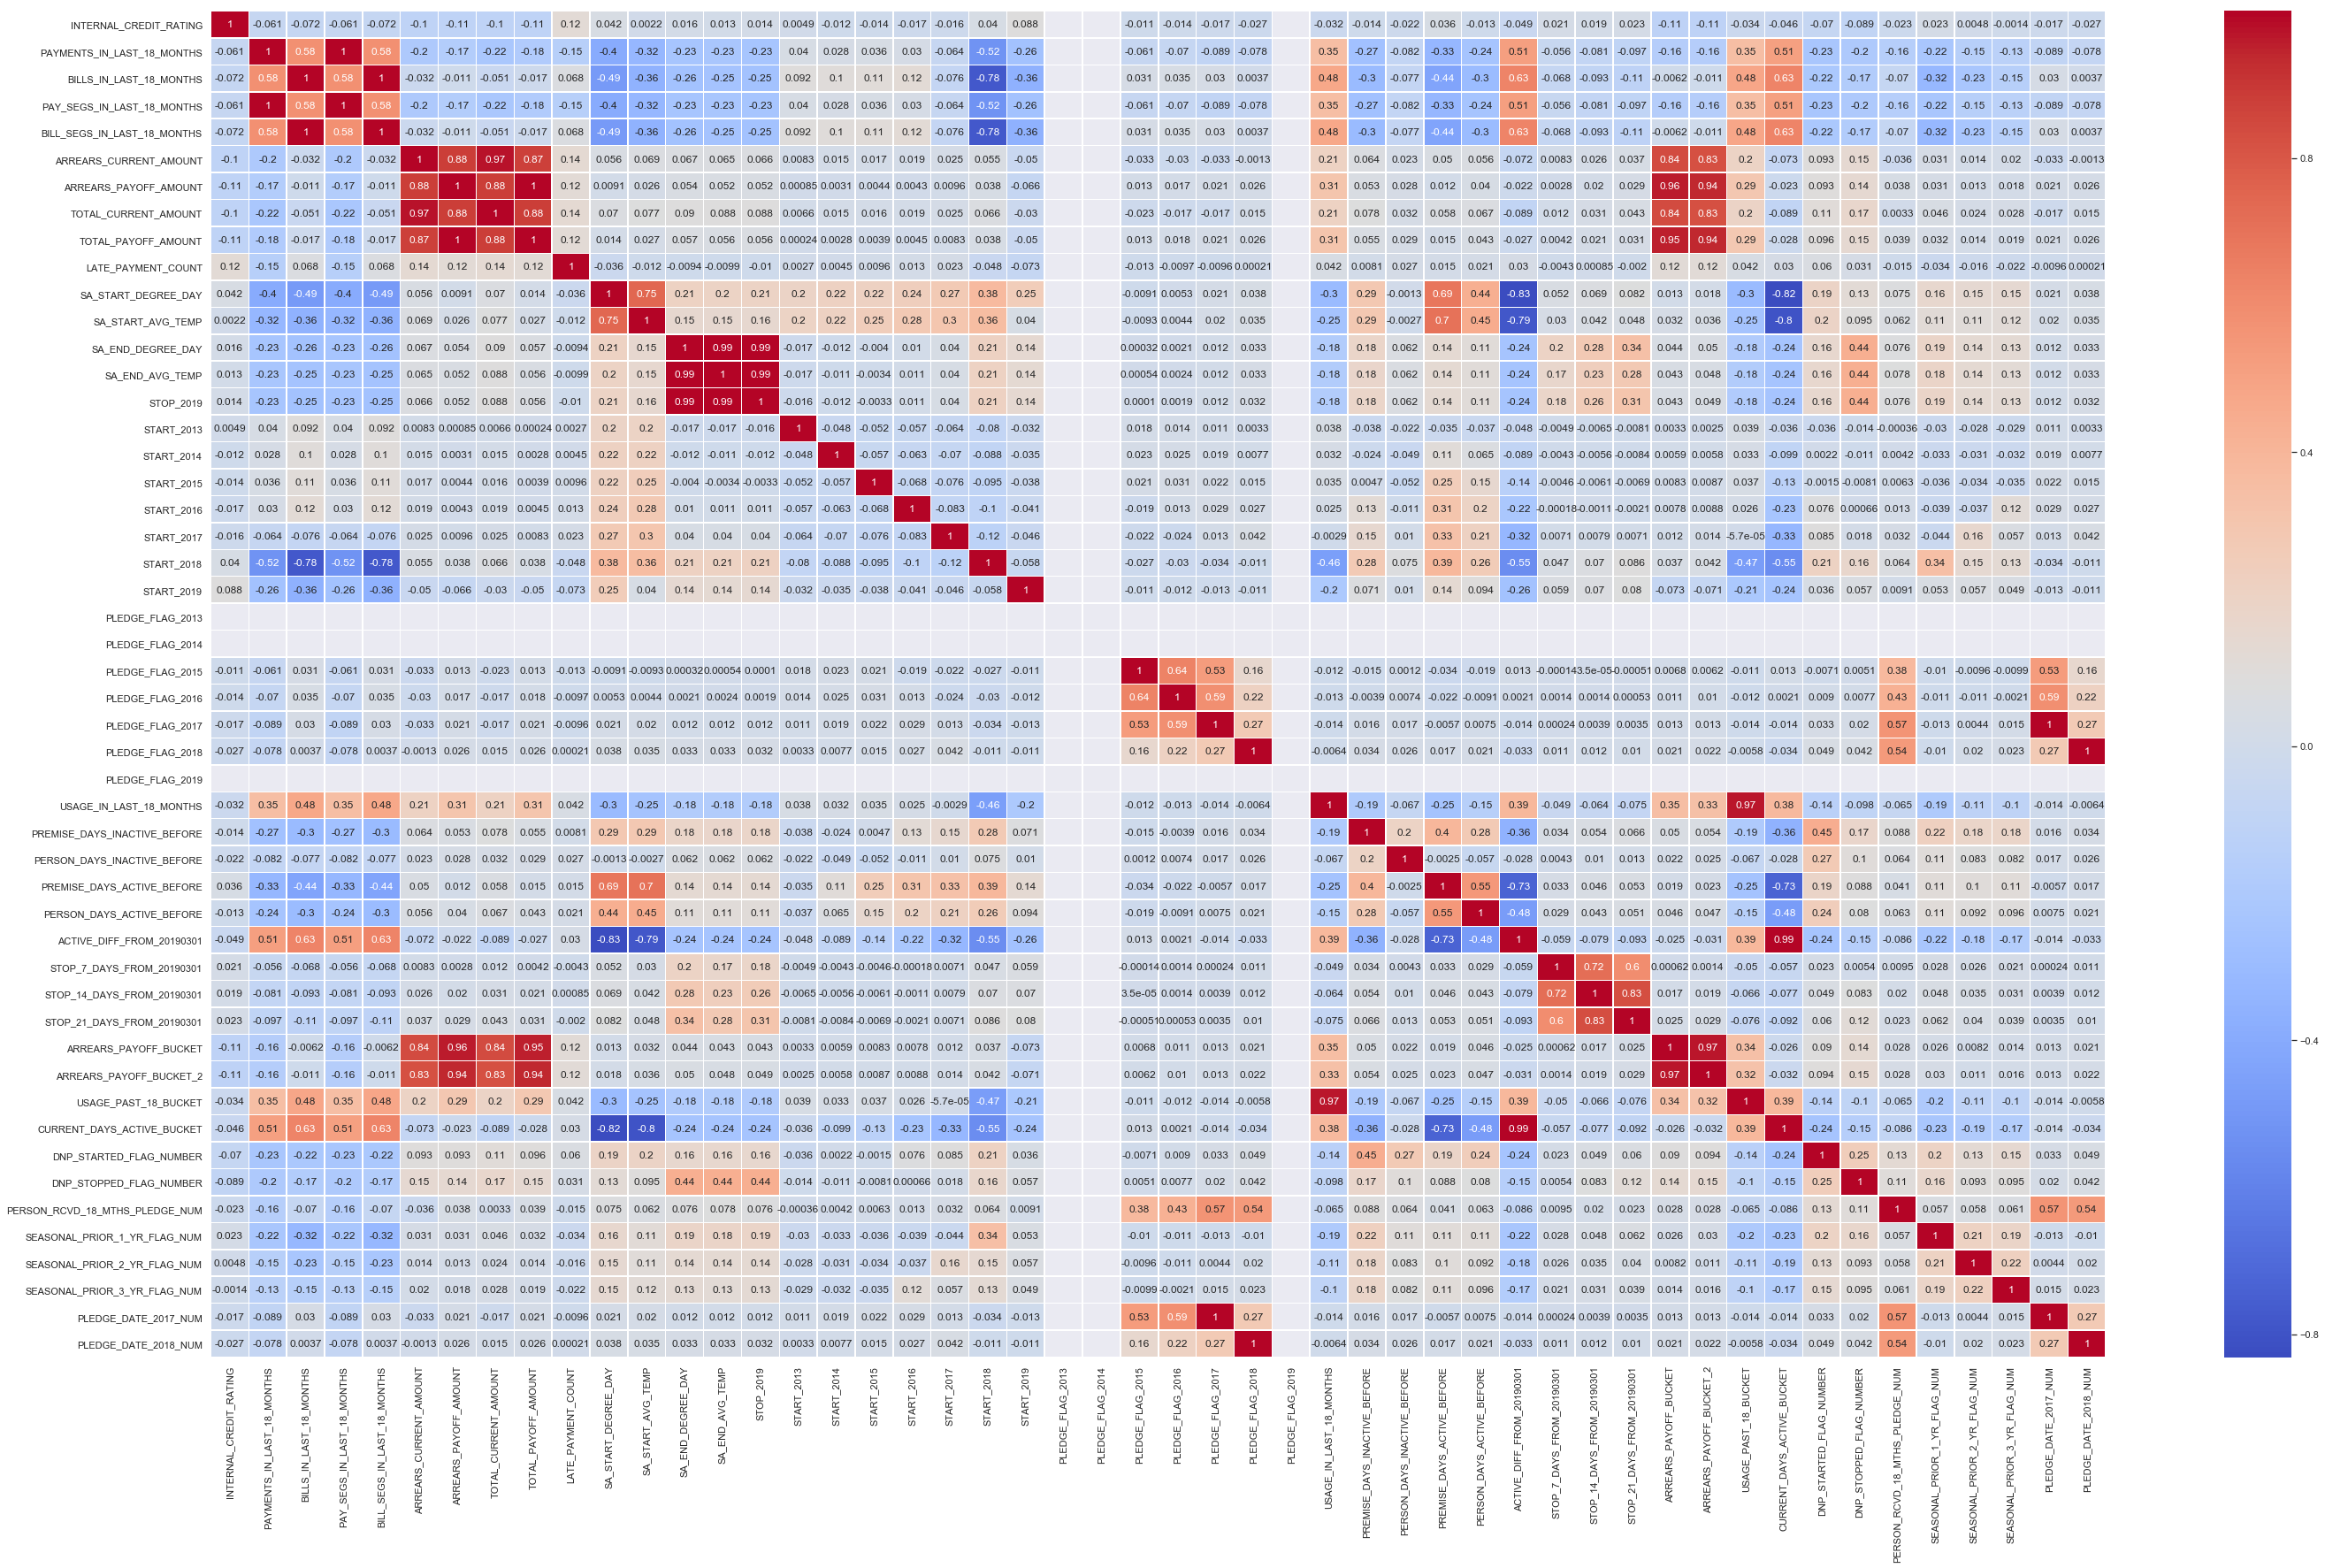

,INTERNAL_CREDIT_RATING,PAYMENTS_IN_LAST_18_MONTHS,BILLS_IN_LAST_18_MONTHS,PAY_SEGS_IN_LAST_18_MONTHS,BILL_SEGS_IN_LAST_18_MONTHS,ARREARS_CURRENT_AMOUNT,ARREARS_PAYOFF_AMOUNT,TOTAL_CURRENT_AMOUNT,TOTAL_PAYOFF_AMOUNT,LATE_PAYMENT_COUNT,...,USAGE_PAST_18_BUCKET,CURRENT_DAYS_ACTIVE_BUCKET,DNP_STARTED_FLAG_NUMBER,DNP_STOPPED_FLAG_NUMBER,PERSON_RCVD_18_MTHS_PLEDGE_NUM,SEASONAL_PRIOR_1_YR_FLAG_NUM,SEASONAL_PRIOR_2_YR_FLAG_NUM,SEASONAL_PRIOR_3_YR_FLAG_NUM,PLEDGE_DATE_2017_NUM,PLEDGE_DATE_2018_NUM
INTERNAL_CREDIT_RATING,1.000000,-0.060712,-0.072485,-0.060712,-0.072485,-0.102138,-0.106652,-0.104645,-0.106061,0.124828,...,-0.033701,-0.046020,-0.069740,-0.089212,-0.022970,0.022516,0.004835,-0.001435,-0.017204,-0.026726
PAYMENTS_IN_LAST_18_MONTHS,-0.060712,1.000000,0.583243,1.000000,0.583243,-0.196626,-0.172830,-0.217652,-0.180382,-0.151473,...,0.353334,0.509541,-0.228105,-0.198488,-0.155263,-0.224282,-0.149620,-0.127255,-0.089079,-0.078160
BILLS_IN_LAST_18_MONTHS,-0.072485,0.583243,1.000000,0.583243,1.000000,-0.031598,-0.010698,-0.050628,-0.016912,0.067514,...,0.482239,0.628795,-0.215528,-0.173294,-0.069708,-0.317644,-0.226454,-0.148999,0.029600,0.003735
PAY_SEGS_IN_LAST_18_MONTHS,-0.060712,1.000000,0.583243,1.000000,0.583243,-0.196626,-0.172830,-0.217652,-0.180382,-0.151473,...,0.353334,0.509541,-0.228105,-0.198488,-0.155263,-0.224282,-0.149620,-0.127255,-0.089079,-0.078160
BILL_SEGS_IN_LAST_18_MONTHS,-0.072485,0.583243,1.000000,0.583243,1.000000,-0.031598,-0.010698,-0.050628,-0.016912,0.067514,...,0.482239,0.628795,-0.215528,-0.173294,-0.069708,-0.317644,-0.226454,-0.148999,0.029600,0.003735
ARREARS_CURRENT_AMOUNT,-0.102138,-0.196626,-0.031598,-0.196626,-0.031598,1.000000,0.878505,0.973152,0.873712,0.140000,...,0.201475,-0.072920,0.092663,0.145230,-0.036076,0.030965,0.013834,0.019960,-0.032767,-0.001318
ARREARS_PAYOFF_AMOUNT,-0.106652,-0.172830,-0.010698,-0.172830,-0.010698,0.878505,1.000000,0.878564,0.995645,0.120892,...,0.292929,-0.022942,0.093117,0.144973,0.038012,0.030501,0.013092,0.017524,0.020579,0.025544
TOTAL_CURRENT_AMOUNT,-0.104645,-0.217652,-0.050628,-0.217652,-0.050628,0.973152,0.878564,1.000000,0.883470,0.137625,...,0.197049,-0.089001,0.110630,0.166470,0.003321,0.045860,0.023726,0.027879,-0.017282,0.014629
TOTAL_PAYOFF_AMOUNT,-0.106061,-0.180382,-0.016912,-0.180382,-0.016912,0.873712,0.995645,0.883470,1.000000,0.121705,...,0.291369,-0.027570,0.095926,0.148155,0.039488,0.031984,0.014380,0.018544,0.021154,0.025711
LATE_PAYMENT_COUNT,0.124828,-0.151473,0.067514,-0.151473,0.067514,0.140000,0.120892,0.137625,0.121705,1.000000,...,0.041636,0.029960,0.060144,0.030776,-0.015129,-0.034130,-0.016305,-0.021644,-0.009609,0.000207


In [38]:
fig, ax = plt.subplots(figsize=(48,28))

# sns.set(font_scale=2.5)
sns.heatmap(df2.corr(method='spearman'), annot=True, linewidth=.5, cmap='coolwarm')
# plt.xticks(fontsize=28, rotation=90)
# plt.yticks(fontsize=28, rotation=0)

plt.show()

df2.corr(method='spearman')

### Bootstrap Estimate of Stopping with X Days of 3/1/2019
This is showing that for active SAs on 3/1/2019, the 95% confidence interval for the number of SAs Stopping between 3/1/2019 and 3/7/2019 is from .34% to .38%.  

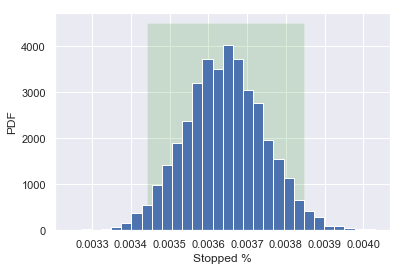


Bootstrap 95% Confidence Interval
[0.00344081 0.00384819]


In [39]:
bs_replicates = np.empty(10000)

for i in range(10000):
    bs_replicates[i] = bootstrap_replicate_1d(df2['STOP_7_DAYS_FROM_20190301'], np.mean)
    
_ = plt.hist(bs_replicates, bins=30, density=True)
_ = plt.xlabel('Stopped %')
_ = plt.ylabel('PDF')
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

plt.fill_between(conf_int, 0, 4500, facecolor='green', alpha = .15, interpolate=True)

plt.show()

print()

print('Bootstrap 95% Confidence Interval')
print(conf_int)

For active SAs on 3/1/2019, the 95% confidence interval for the number of SAs Stopping between 3/1/2019 and 3/14/2019 is from .67% to .72%.  

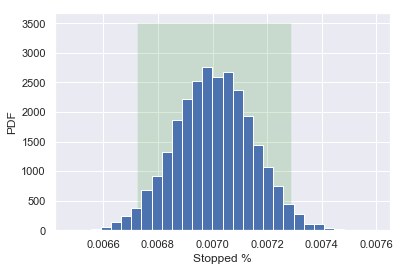


Bootstrap 95% Confidence Interval
[0.00672328 0.00728607]


In [40]:

bs_replicates = np.empty(10000)

for i in range(10000):
    bs_replicates[i] = bootstrap_replicate_1d(df2['STOP_14_DAYS_FROM_20190301'], np.mean)
    
_ = plt.hist(bs_replicates, bins=30, density=True)
_ = plt.xlabel('Stopped %')
_ = plt.ylabel('PDF')
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

plt.fill_between(conf_int, 0, 3500, facecolor='green', alpha = .15, interpolate=True)

plt.show()

print()

print('Bootstrap 95% Confidence Interval')
print(conf_int)

For active SAs on 3/1/2019, the 95% confidence interval for the number of SAs Stopping between 3/1/2019 and 3/21/2019 is from .98% to 1.04%.  

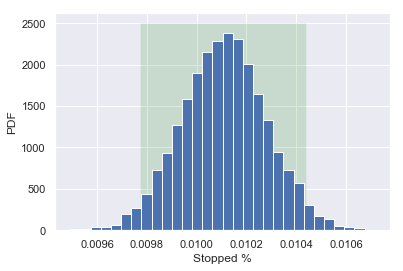


Bootstrap 95% Confidence Interval
[0.00977435 0.01043966]


In [41]:

bs_replicates = np.empty(10000)

for i in range(10000):
    bs_replicates[i] = bootstrap_replicate_1d(df2['STOP_21_DAYS_FROM_20190301'], np.mean) #df['STOP_21_DAYS_FROM_20190301'], np.mean)
    
_ = plt.hist(bs_replicates, bins=30, density=True)
_ = plt.xlabel('Stopped %')
_ = plt.ylabel('PDF')
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

plt.fill_between(conf_int, 0, 2500, facecolor='green', alpha = .15, interpolate=True)

plt.show()

print()

print('Bootstrap 95% Confidence Interval')
print(conf_int)

### Feature Selection (Lasso)
Using the 21 day (3/1/2019 - 3/21/2019) timeframe.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


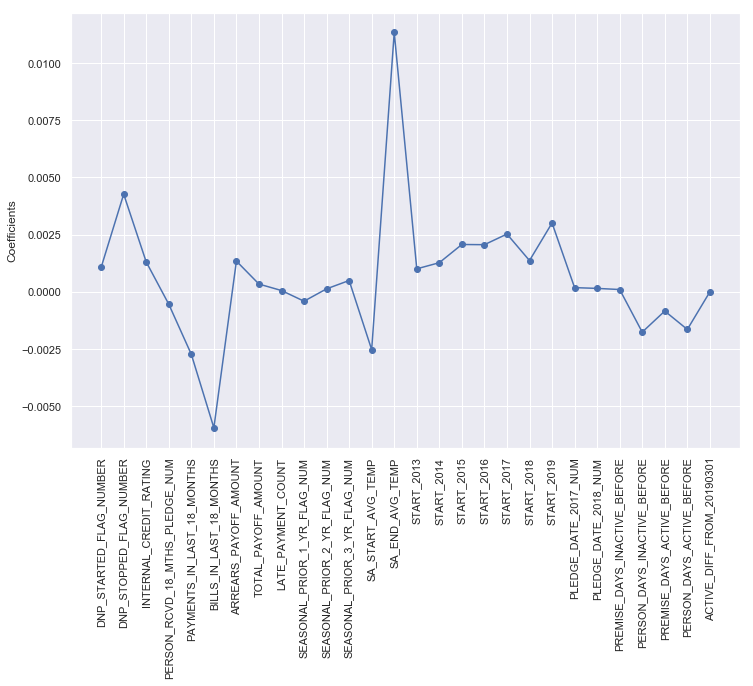

In [42]:
# Lasso

names = X.columns
scaler = StandardScaler() # Standarize features
X_std = scaler.fit_transform(X_train)

lasso = Lasso(alpha=.00000001)
#lasso_coef = lasso.fit(X_train, y_train).coef_
lasso_coef = lasso.fit(X_std, y_train).coef_

_ = plt.figure(figsize=(12,8))
_ = plt.plot(range(len(names)), lasso_coef, marker = 'o')
_ = plt.xticks(range(len(names)), names, rotation = 90)
_ = plt.ylabel('Coefficients')
plt.show()

In [43]:
# Lasso Training/Testing Scores

lasso = Lasso(alpha=.00000001)
lasso.fit(X_std,y_train)
train_score=lasso.score(X_std,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)

print('Training Score:', train_score)
print('Test Score: ', test_score)
print('Number of features used: ', coeff_used)

Training Score: 0.03784243571538337
Test Score:  -1404.5276398644698
Number of features used:  28


In [16]:
# Output full dataframe
filename = 'eda_out.csv'
df.to_csv(filename)

# Output Active SAs as of 3/1/2019 dataset.
filename = 'eda_active_out.csv'
df2.to_csv(filename)

## ANNEX

This is showing the Pearson Correlation using the entire dataframe.

In [17]:
df[cont_vars].corr(method='pearson')

,INTERNAL_CREDIT_RATING,PAYMENTS_IN_LAST_18_MONTHS,BILLS_IN_LAST_18_MONTHS,PAY_SEGS_IN_LAST_18_MONTHS,BILL_SEGS_IN_LAST_18_MONTHS,ARREARS_CURRENT_AMOUNT,ARREARS_PAYOFF_AMOUNT,TOTAL_CURRENT_AMOUNT,TOTAL_PAYOFF_AMOUNT,LATE_PAYMENT_COUNT,...,SA_END_AVG_TEMP,USAGE_IN_LAST_18_MONTHS,PREMISE_DAYS_INACTIVE_BEFORE,PERSON_DAYS_INACTIVE_BEFORE,PREMISE_DAYS_ACTIVE_BEFORE,PERSON_DAYS_ACTIVE_BEFORE,ACTIVE_DIFF_FROM_20190301,STOP_7_DAYS_FROM_20190301,STOP_14_DAYS_FROM_20190301,STOP_21_DAYS_FROM_20190301
INTERNAL_CREDIT_RATING,1.000000,0.094890,0.067115,0.094890,0.067115,-0.017965,-0.014215,-0.013164,-0.010355,0.021483,...,-0.089881,0.001484,0.005125,0.006320,0.035625,0.004029,-0.032171,0.018757,0.017502,0.021222
PAYMENTS_IN_LAST_18_MONTHS,0.094890,1.000000,0.927496,1.000000,0.927496,0.138330,0.162927,0.092889,0.111797,0.127707,...,-0.714975,0.034869,-0.091942,-0.023126,0.017562,0.040085,0.383108,-0.003499,-0.007732,-0.009189
BILLS_IN_LAST_18_MONTHS,0.067115,0.927496,1.000000,0.927496,1.000000,0.186383,0.212261,0.126854,0.146190,0.246055,...,-0.742298,0.021640,-0.079783,-0.015742,0.020181,0.045331,0.385541,0.003442,0.005726,0.006683
PAY_SEGS_IN_LAST_18_MONTHS,0.094890,1.000000,0.927496,1.000000,0.927496,0.138330,0.162927,0.092889,0.111797,0.127707,...,-0.714975,0.034869,-0.091942,-0.023126,0.017562,0.040085,0.383108,-0.003499,-0.007732,-0.009189
BILL_SEGS_IN_LAST_18_MONTHS,0.067115,0.927496,1.000000,0.927496,1.000000,0.186383,0.212261,0.126854,0.146190,0.246055,...,-0.742298,0.021640,-0.079783,-0.015742,0.020181,0.045331,0.385541,0.003442,0.005726,0.006683
ARREARS_CURRENT_AMOUNT,-0.017965,0.138330,0.186383,0.138330,0.186383,1.000000,0.977980,0.566027,0.562069,0.124704,...,-0.154860,0.079480,0.010440,-0.000654,0.017307,0.018378,-0.031941,0.023568,0.038203,0.045849
ARREARS_PAYOFF_AMOUNT,-0.014215,0.162927,0.212261,0.162927,0.212261,0.977980,1.000000,0.557182,0.579637,0.122746,...,-0.178848,0.078286,0.008012,0.000382,0.015653,0.018696,-0.014803,0.022344,0.036558,0.043887
TOTAL_CURRENT_AMOUNT,-0.013164,0.092889,0.126854,0.092889,0.126854,0.566027,0.557182,1.000000,0.990323,0.084180,...,-0.104567,0.065466,0.008354,0.000322,0.015790,0.012367,-0.025146,0.016795,0.027279,0.032851
TOTAL_PAYOFF_AMOUNT,-0.010355,0.111797,0.146190,0.111797,0.146190,0.562069,0.579637,0.990323,1.000000,0.083633,...,-0.123249,0.065248,0.005665,0.000387,0.014798,0.012625,-0.011791,0.015627,0.025531,0.030717
LATE_PAYMENT_COUNT,0.021483,0.127707,0.246055,0.127707,0.246055,0.124704,0.122746,0.084180,0.083633,1.000000,...,-0.159353,-0.001144,-0.018572,0.014674,0.026433,0.035359,-0.019756,0.004908,0.014581,0.015774


In [18]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df2['ACTIVE_DIFF_FROM_20190301'], y=df2['STOP_7_DAYS_FROM_20190301'], alpha=.05)

print('Dependent: Stopped within 7 Days of 3/1/2019')
print('Independent: # of Days Active as of 3/1/2019')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Stopped within 7 Days of 3/1/2019
Independent: # of Days Active as of 3/1/2019
p-value: 5.0499922703886e-116
r: -0.03918298316485295
r^2: 0.0015353061696971495
CI: -0.04253279269094256 to -0.035832292692932456


In [19]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df2['ACTIVE_DIFF_FROM_20190301'], y=df2['STOP_14_DAYS_FROM_20190301'], alpha=.05)

print('Dependent: Stopped within 14 Days of 3/1/2019')
print('Independent: # of Days Active as of 3/1/2019')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Stopped within 14 Days of 3/1/2019
Independent: # of Days Active as of 3/1/2019
p-value: 8.390251710385442e-206
r: -0.052371605408611833
r^2: 0.0027427850530753403
CI: -0.05571721585659486 to -0.04902481892068043


Here is the heatmap for the above Pearson Correlation.

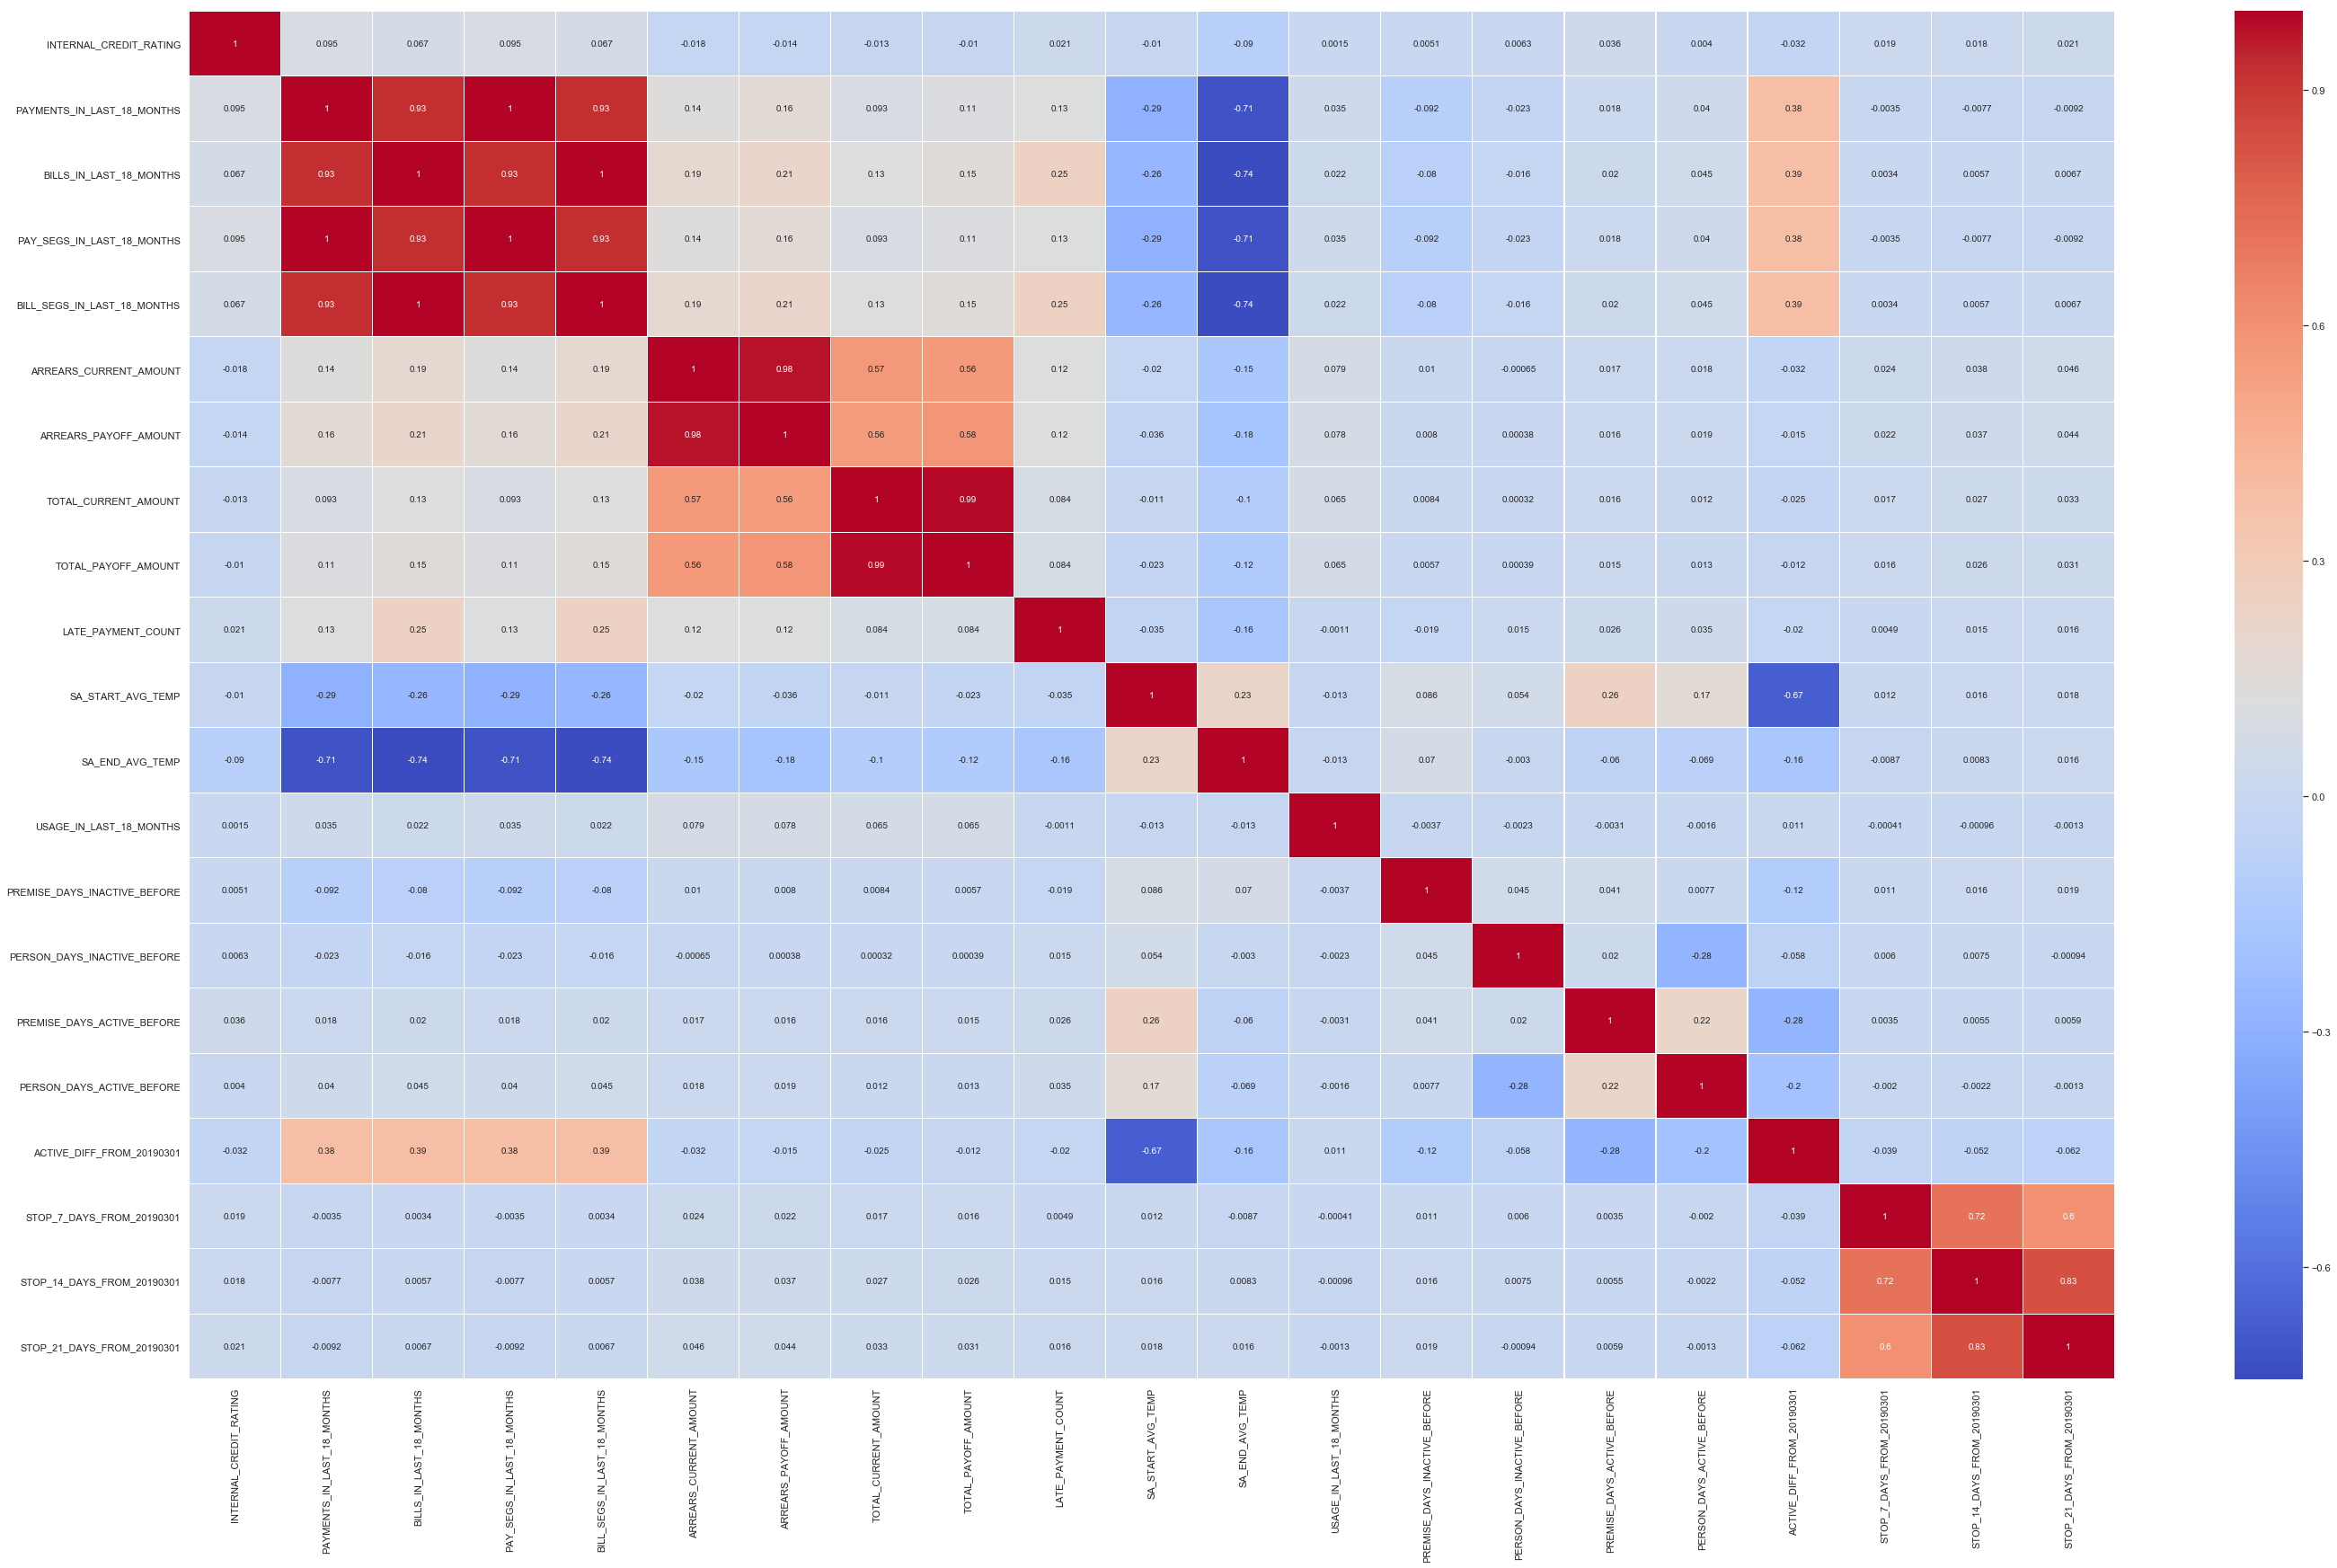

In [20]:
fig, ax = plt.subplots(figsize=(48,28))

# sns.set(font_scale=2.5)
sns.heatmap(df[cont_vars].corr(method='pearson'), annot=True, linewidth=.1, cmap='coolwarm')
#sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})  
# plt.xticks(fontsize=28, rotation=90)
# plt.yticks(fontsize=28, rotation=0)

plt.show()

Full dataset:

In [21]:
r, p, low, high = pearsonr_ci(x=df['LATE_PAYMENT_COUNT'], y=df['STOP_21_DAYS_FROM_20190301'], alpha=.05)

print('Dependent: Stopped within 21 Days of 3/1/2019')
print('Independent: Late Payment Count')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Stopped within 21 Days of 3/1/2019
Independent: Late Payment Count
p-value: 6.0146254786899404e-36
r: 0.015774027281559886
r^2: 0.00024881993667939556
CI: 0.013304465465856967 to 0.018243396661131273


In [22]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['PAYMENTS_IN_LAST_18_MONTHS'], y=df['BILLS_IN_LAST_18_MONTHS'], alpha=.05)

print('Dependent: Bills in Last 18 Months')
print('Independent: Payments in Last 18 Months')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Bills in Last 18 Months
Independent: Payments in Last 18 Months
p-value: 0.0
r: 0.9274957099869824
r^2: 0.8602482920442566
CI: 0.9271497193998164 to 0.9278401188766876


In [23]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['TOTAL_PAYOFF_AMOUNT'], y=df['LATE_PAYMENT_COUNT'], alpha=.05)

print('Dependent: Late Payment Count')
print('Independent: Total Payoff Amount')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Late Payment Count
Independent: Total Payoff Amount
p-value: 0.0
r: 0.08363329300963945
r^2: 0.006994527699636208
CI: 0.08117998304784477 to 0.08608558956662306


Spearman Correlation Heatmap using the full dataset.

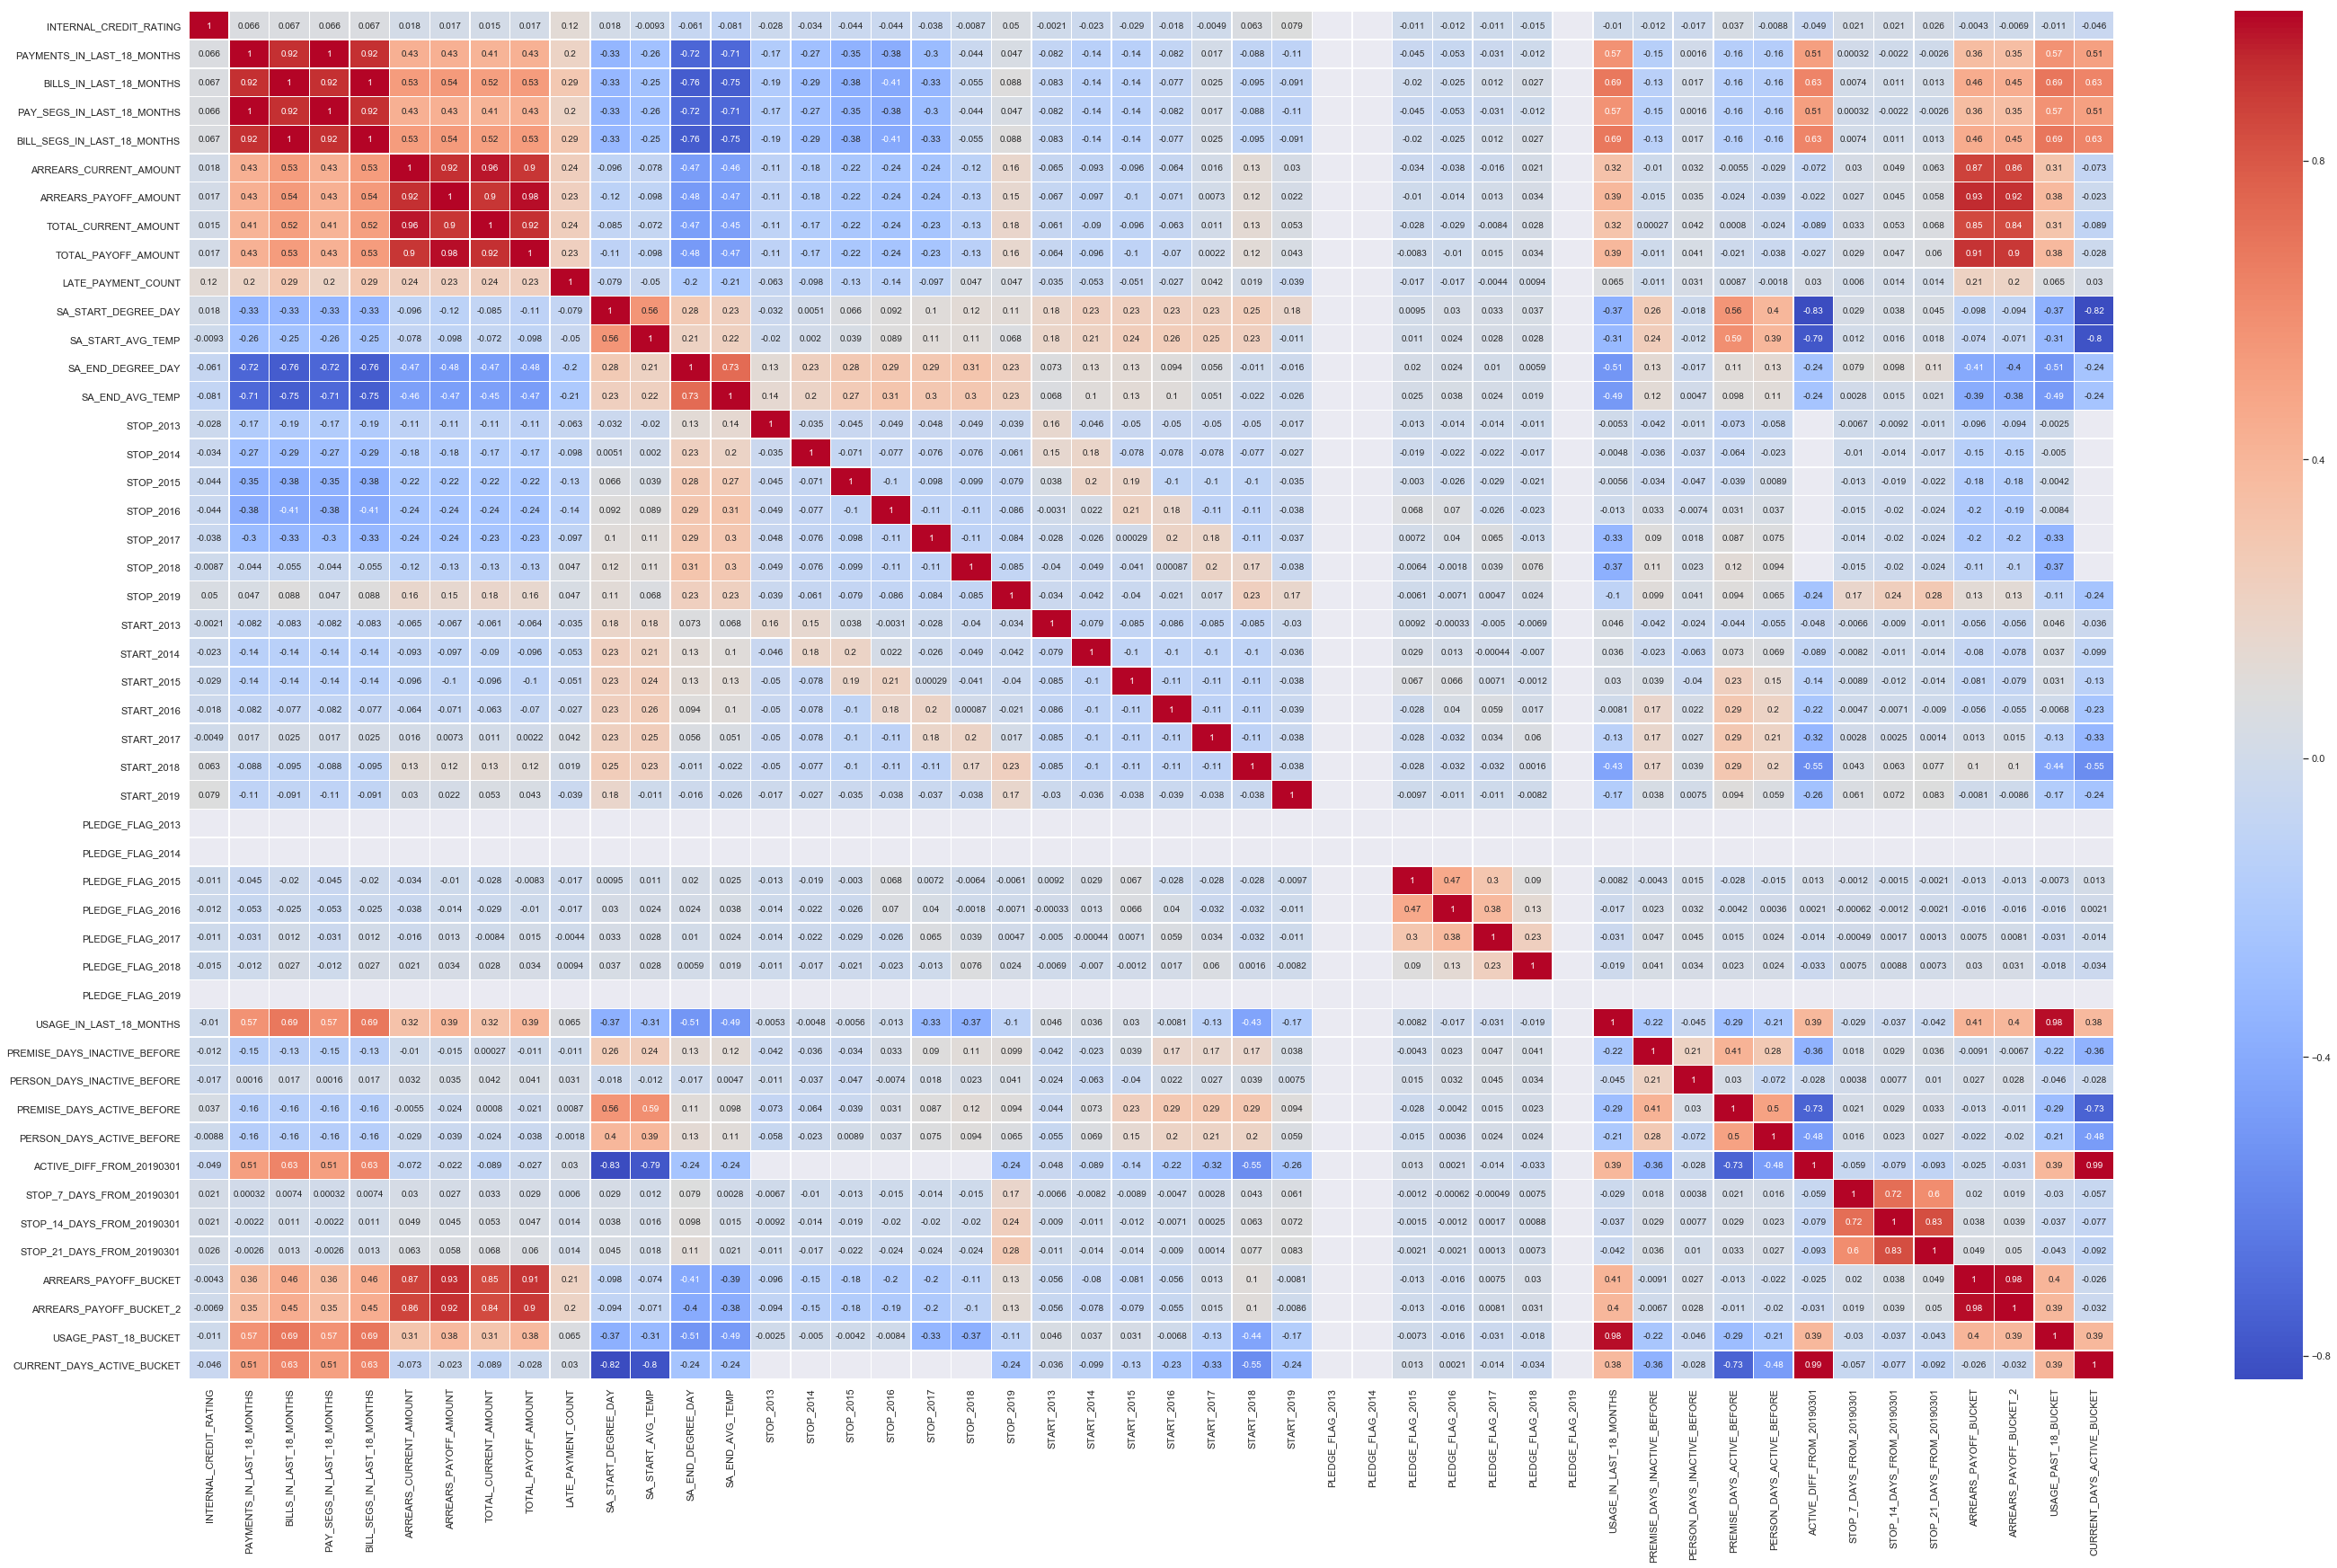

,INTERNAL_CREDIT_RATING,PAYMENTS_IN_LAST_18_MONTHS,BILLS_IN_LAST_18_MONTHS,PAY_SEGS_IN_LAST_18_MONTHS,BILL_SEGS_IN_LAST_18_MONTHS,ARREARS_CURRENT_AMOUNT,ARREARS_PAYOFF_AMOUNT,TOTAL_CURRENT_AMOUNT,TOTAL_PAYOFF_AMOUNT,LATE_PAYMENT_COUNT,...,PREMISE_DAYS_ACTIVE_BEFORE,PERSON_DAYS_ACTIVE_BEFORE,ACTIVE_DIFF_FROM_20190301,STOP_7_DAYS_FROM_20190301,STOP_14_DAYS_FROM_20190301,STOP_21_DAYS_FROM_20190301,ARREARS_PAYOFF_BUCKET,ARREARS_PAYOFF_BUCKET_2,USAGE_PAST_18_BUCKET,CURRENT_DAYS_ACTIVE_BUCKET
INTERNAL_CREDIT_RATING,1.000000,0.065523,0.067451,0.065523,0.067451,0.017826,0.016888,0.015043,0.017178,0.123123,...,0.037459,-0.008817,-0.048570,0.021309,0.021376,0.025941,-0.004316,-0.006877,-0.011426,-0.046020
PAYMENTS_IN_LAST_18_MONTHS,0.065523,1.000000,0.916104,1.000000,0.916104,0.429086,0.433829,0.413258,0.427691,0.199702,...,-0.155792,-0.160391,0.514075,0.000322,-0.002167,-0.002640,0.360391,0.350523,0.574654,0.509541
BILLS_IN_LAST_18_MONTHS,0.067451,0.916104,1.000000,0.916104,1.000000,0.531769,0.537303,0.519751,0.534247,0.288572,...,-0.155199,-0.157283,0.634077,0.007351,0.011329,0.013440,0.456042,0.445982,0.688069,0.628795
PAY_SEGS_IN_LAST_18_MONTHS,0.065523,1.000000,0.916104,1.000000,0.916104,0.429086,0.433829,0.413258,0.427691,0.199702,...,-0.155792,-0.160391,0.514075,0.000322,-0.002167,-0.002640,0.360391,0.350523,0.574654,0.509541
BILL_SEGS_IN_LAST_18_MONTHS,0.067451,0.916104,1.000000,0.916104,1.000000,0.531769,0.537303,0.519751,0.534247,0.288572,...,-0.155199,-0.157283,0.634077,0.007351,0.011329,0.013440,0.456042,0.445982,0.688069,0.628795
ARREARS_CURRENT_AMOUNT,0.017826,0.429086,0.531769,0.429086,0.531769,1.000000,0.920973,0.964814,0.902280,0.240260,...,-0.005500,-0.029393,-0.072361,0.029942,0.049197,0.062649,0.868824,0.858461,0.313249,-0.072920
ARREARS_PAYOFF_AMOUNT,0.016888,0.433829,0.537303,0.433829,0.537303,0.920973,1.000000,0.903769,0.984856,0.227886,...,-0.024278,-0.038713,-0.021810,0.026887,0.045240,0.057586,0.930476,0.919768,0.379997,-0.022942
TOTAL_CURRENT_AMOUNT,0.015043,0.413258,0.519751,0.413258,0.519751,0.964814,0.903769,1.000000,0.918435,0.241041,...,0.000801,-0.024447,-0.088858,0.032978,0.053303,0.067656,0.846657,0.835560,0.308983,-0.089001
TOTAL_PAYOFF_AMOUNT,0.017178,0.427691,0.534247,0.427691,0.534247,0.902280,0.984856,0.918435,1.000000,0.231729,...,-0.021481,-0.037665,-0.026799,0.028619,0.047224,0.060126,0.909255,0.897756,0.378937,-0.027570
LATE_PAYMENT_COUNT,0.123123,0.199702,0.288572,0.199702,0.288572,0.240260,0.227886,0.241041,0.231729,1.000000,...,0.008713,-0.001817,0.030274,0.006046,0.014056,0.014254,0.207211,0.204065,0.064582,0.029960


In [24]:
fig, ax = plt.subplots(figsize=(48,28))

# sns.set(font_scale=2.5)
sns.heatmap(df.corr(method='spearman'), annot=True, linewidth=.5, cmap='coolwarm')
# plt.xticks(fontsize=28, rotation=90)
# plt.yticks(fontsize=28, rotation=0)

plt.show()

df.corr(method='spearman')

In [25]:
df['STOP_7_DAYS_FROM_20190301'][((df['SA_START_YEAR_MONTH']  < '201903') & (df['SA_END_YEAR_MONTH'] >= '201903'))].describe()

count    341199.000000
mean          0.003643
std           0.060248
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: STOP_7_DAYS_FROM_20190301, dtype: float64

In [26]:
df2.loc[(df2['STOP_21_DAYS_FROM_20190301'] == 1)].count()
df2.count()

#df2['STOP_21_DAYS_FROM_20190301'].describe()

CIS_DIVISION                      341199
ACCOUNT_ID                        341199
CUSTOMER_CLASS_CODE               341199
CUSTOMER_CLASS_DESCRIPTION        341199
PERSON_ID                         341199
SA_START_DATE                     341199
SA_START_YEAR                     341199
SA_START_YEAR_MONTH               341199
SA_END_DATE                       341199
SA_END_YEAR                       341199
SA_END_YEAR_MONTH                 341199
SA_STATUS_FLAG                    341199
SA_TYPE_CODE                      341199
RATE_CLASS_CODE                   341199
RATE_CLASS_DESCRIPTION            341199
PREMISE_ID                        341199
CITY                              341199
STATE                             341199
POSTAL                            341199
BILL_CYCLE_CODE                   341199
BILL_CYCLE_DESCRIPTION            341199
SERVICE_TYPE_CODE                 341199
PREMISE_TYPE_CODE                 341199
TREND_AREA_CODE                   341199
OFFICE_LOCATION 

In [27]:
# df2 is a copy of df but only has SAs that should be considered when looking at stops from 3/1/2019.
# df2 = df.copy() 
# df2 = df2.loc[((df2['SA_START_YEAR_MONTH']  < '201903') & (df2['SA_END_YEAR_MONTH'] >= '201903') )]



In [28]:
# tmp = df[cont_vars].corr(method='pearson')
# filename = 'tmp.csv'
# tmp.to_csv(filename)